# Projection on vertical modes

In [1]:
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
%matplotlib inline

import crocosi.postp as pp
from crocosi.gridop import get_z, N2Profile
import crocosi.gridop as gp

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:60994 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 28 Memory: 107.37 GB


# Read netcdf file

In [3]:
root_path = '/home/datawork-lops-osi/aponte/bturb_itide/jet/'
run = 'jet_cfg1_wp6_4km_nodecay_2000a2300j/'

gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=[], grid_params=gparams, verbose=True)

### fixing a few stuff. WARNING quick & dirty
# time is nan
r['his'].coords['mytime'] = xr.DataArray(np.arange(r['his']["time"].size), dims=["time"])

r['his']

Analysing directory /home/datawork-lops-osi/aponte/bturb_itide/jet/jet_cfg1_wp6_4km_nodecay_2000a2300j/
Found 3 segments
Found 12 his files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected y_itide = 400000.0 m
Detected jet_ywidth = 800000.0 m
Detected jet_weight = 0.6
Detected omega = 0.000145444104333 1/s
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['his']
Grid size: (L ,M, N) = (258, 722, 50)


<xarray.Dataset>
Dimensions:              (axis_nbounds: 2, s_rho: 50, s_w: 51, time: 12, x_rho: 258, x_u: 257, x_v: 258, x_w: 258, y_rho: 722, y_u: 722, y_v: 721, y_w: 722)
Coordinates:
    xi_u                 (y_u, x_u) float32 dask.array<chunksize=(722, 257), meta=np.ndarray>
    eta_w                (y_w, x_w) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    xi_v                 (y_v, x_v) float32 dask.array<chunksize=(721, 258), meta=np.ndarray>
    eta_rho              (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    xi_rho               (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    eta_v                (y_v, x_v) float32 dask.array<chunksize=(721, 258), meta=np.ndarray>
    eta_u                (y_u, x_u) float32 dask.array<chunksize=(722, 257), meta=np.ndarray>
    xi_w                 (y_w, x_w) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
  * s_rho                (s_rho) float32 -0.99 -0.97 

# Compute vertical modes

**ssh temporal mean**

<xarray.DataArray 'ssh_a' (y_rho: 722, x_rho: 258)>
dask.array<mean_agg-aggregate, shape=(722, 258), dtype=float32, chunksize=(722, 258), chunktype=numpy.ndarray>
Coordinates:
    eta_rho  (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    xi_rho   (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    f        (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
Dimensions without coordinates: y_rho, x_rho


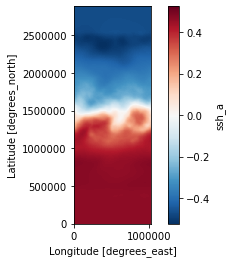

In [4]:
# eventually should also average along x
sshmean = r['his'].ssh_a.mean(dim='time').persist()
print(sshmean)
p = sshmean.plot(x='xi_rho',y='eta_rho')
p.axes.set_aspect('equal')

**Compute z mean from ssh mean**

/home1/datahome/aponte/croco/crocosi/gridop.py:106: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(sc.dims[0], _zeta.dims[0], _zeta.dims[1])
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/worker.py:3221: UserWarning: Large object of size 74.51 MB detected in task graph: 
  (array([[[-9.51529614e-01, -8.61530923e-01, -7.800 ... 4e', 0, 0, 0)")
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


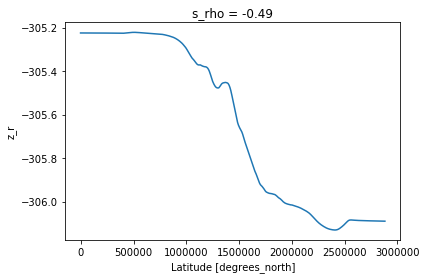

In [5]:
zmean = get_z(r, zeta=sshmean, h=r.ds['his'].h, vgrid='r', hgrid='r').persist()
#zmean.isel(x_rho=125).plot(x='y_rho', y='s_rho')
zmean.isel(x_rho=125).sel(s_rho=-.5, method='nearest').plot(x='eta_rho')

**Interpolate vertically stratification T(x,y,z,t)  on zmean -> T(x,y,$\bar{z}$,t)**

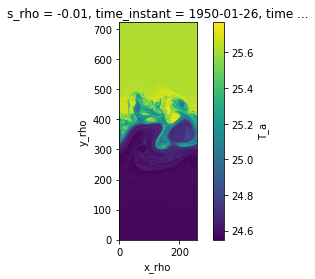

In [6]:
p = r['his'].T_a.isel(time=0,s_rho=-1).plot()
p.axes.set_aspect('equal')

In [7]:
z = get_z(r, zeta=r['his'].ssh_a, h=r['his'].h, vgrid='r', hgrid='r')
T = r['his'].T_a.chunk({'s_rho':None})

In [8]:
z

<xarray.DataArray 'z_r' (time: 12, y_rho: 722, x_rho: 258, s_rho: 50)>
dask.array<add, shape=(12, 722, 258, 50), dtype=float64, chunksize=(1, 722, 258, 50), chunktype=numpy.ndarray>
Coordinates:
    eta_rho       (y_rho, x_rho) float32 -2000.0 -2000.0 ... 2882000.0 2882000.0
    xi_rho        (y_rho, x_rho) float32 -2000.0 2000.0 ... 1022000.0 1026000.0
    time_instant  (time) datetime64[ns] 1950-01-26 1950-02-20 ... 1950-04-11
  * time          (time) float64 2e+03 nan nan nan nan ... nan nan nan nan nan
    f             (y_rho, x_rho) float32 0.00010309763 ... 0.00014977805
    mytime        (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
Dimensions without coordinates: y_rho, x_rho

In [9]:
T

<xarray.DataArray 'T_a' (time: 12, s_rho: 50, y_rho: 722, x_rho: 258)>
dask.array<rechunk-merge, shape=(12, 50, 722, 258), dtype=float32, chunksize=(1, 50, 722, 258), chunktype=numpy.ndarray>
Coordinates:
    eta_rho       (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    xi_rho        (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    time_instant  (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time          (time) float64 2e+03 nan nan nan nan ... nan nan nan nan nan
    f             (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    mytime        (time) int64 dask.array<chunksize=(12,), meta=np.ndarray>
Dimensions without coordinates: y_rho, x_rho
Attributes:
    online_operation:    instant
    interval_operation:  1 d
    interval_write:      25 d
    cell_methods:        time: point (interval: 1 d)

In [10]:
def interp2z_3d(z0, z, v, b_extrap=2, t_extrap=2):
    """
    b_extrap, t_extrap:
        0 set to NaN
        1 set to nearest neighboor
        2 linear extrapolation
    """
    import crocosi.fast_interp3D as fi  # OpenMP accelerated C based interpolator
    # check v and z have identical shape
    assert v.ndim==z.ndim
    # add dimensions if necessary
    if v.ndim == 1:
        lv = v.squeeze()[:,None,None]
        lz = z.squeeze()[:,None,None]
    elif v.ndim == 2:
        lv = v[...,None]
        lz = z[...,None]
    else:
        lz = z[...]
        lv = v[...]
    #
    return fi.interp(z0.astype('float64'), lz.astype('float64'), lv.astype('float64'), 
                     b_extrap, t_extrap)

def interp2z(z0, z, v, b_extrap, t_extrap):
    ''' interpolate vertically
    '''
    # check v and z have identical shape
    assert v.ndim==z.ndim
    # test if temporal dimension is present
    if v.ndim == 4:
        vi = [interp2z_3d(z0, z[...,t], v[...,t], b_extrap, t_extrap)[...,None] 
                  for t in range(v.shape[-1])]
        return np.concatenate(vi, axis=0) # (50, 722, 258, 1)
        #return v*0 + v.shape[3]
    else:
        return interp2z_3d(z0, z, v, b_extrap, t_extrap)


<xarray.DataArray (s_rho: 50, y_rho: 722, x_rho: 258, time: 12)>
dask.array<interp2z, shape=(50, 722, 258, 12), dtype=float64, chunksize=(50, 722, 258, 1), chunktype=numpy.ndarray>
Coordinates:
    eta_rho       (y_rho, x_rho) float32 -2000.0 -2000.0 ... 2882000.0 2882000.0
    xi_rho        (y_rho, x_rho) float32 -2000.0 2000.0 ... 1022000.0 1026000.0
    f             (y_rho, x_rho) float32 0.00010309763 ... 0.00014977805
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    time_instant  (time) datetime64[ns] 1950-01-26 1950-02-20 ... 1950-04-11
  * time          (time) float64 2e+03 nan nan nan nan ... nan nan nan nan nan
    mytime        (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
    z_rho         (s_rho, y_rho, x_rho) float64 dask.array<chunksize=(50, 722, 258), meta=np.ndarray>
Dimensions without coordinates: y_rho, x_rho


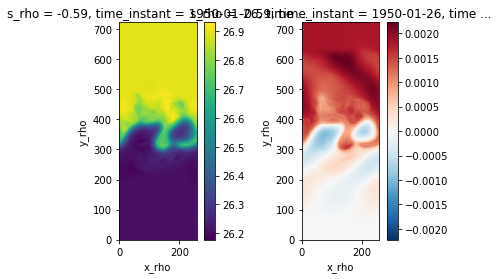

In [11]:
Ti = xr.apply_ufunc(interp2z, zmean, z, T, 2, 2, 
                    dask='parallelized', output_dtypes=[np.float64])
Ti = Ti.assign_coords(z_rho=zmean)
print(Ti)

ax = plt.subplot(1,2,1)
Ti.isel(time=0, s_rho=20).plot(ax=ax)
ax.set_aspect('equal')
#
ax = plt.subplot(1,2,2)
(T-Ti).isel(time=0, s_rho=20).plot(ax=ax)
ax.set_aspect('equal')

**Temporal mean of stratification T(x,y,$\bar{z}$,t) -> T(x,y,$\bar{z}$)**

<xarray.DataArray (s_rho: 50, y_rho: 722, x_rho: 258)>
dask.array<mean_agg-aggregate, shape=(50, 722, 258), dtype=float64, chunksize=(50, 722, 258), chunktype=numpy.ndarray>
Coordinates:
    eta_rho  (y_rho, x_rho) float32 -2000.0 -2000.0 ... 2882000.0 2882000.0
    xi_rho   (y_rho, x_rho) float32 -2000.0 2000.0 ... 1022000.0 1026000.0
    f        (y_rho, x_rho) float32 0.00010309763 ... 0.00014977805
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
    z_rho    (s_rho, y_rho, x_rho) float64 dask.array<chunksize=(50, 722, 258), meta=np.ndarray>
Dimensions without coordinates: y_rho, x_rho


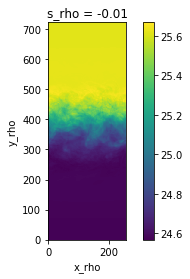

In [12]:
Tmean = Ti.mean(dim='time')
print(Tmean)
p = Tmean.isel(s_rho=-1).plot()
p.axes.set_aspect('equal')

**Compute N2 profile from stratification on mean z  T(x,y,$\bar{z}$) -> N2(x,y,$\bar{z}$)**

<xarray.DataArray (s_w: 51, y_rho: 722, x_rho: 258)>
dask.array<truediv, shape=(51, 722, 258), dtype=float64, chunksize=(49, 722, 258), chunktype=numpy.ndarray>
Dimensions without coordinates: s_w, y_rho, x_rho


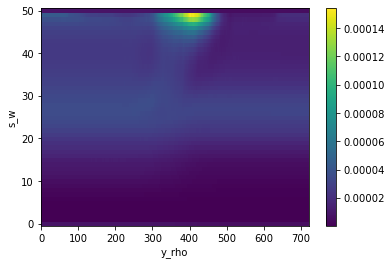

In [13]:
N2 = N2Profile(r,Tmean,zmean).persist()
print(N2)
p = N2.mean(dim="x_rho").plot()
#p.axes.set_aspect('equal')

**Compute vertical modes N2(x,y,$\bar{z}$) -> $\phi_{n}$(x,y,$\bar{z}$)**

Trying to parallelize with dask. Doesn't work:
* z-dim is a core dim (cannot distribute among vertical levels)
* need to solve separate eigenproblem on each non-z-dim point. This should be distributed / parallelized
* vectorize does not allow for parallelization: hence need to vectorize inside the function wrapped by apply_ufunc, which is the purpose of the wrapper "compmodes", calling "compmodes_1pt"
* trying to return a stack of cn, phin and dphi, using new dim s_stack. This fails when calling apply_ufunc with dask (although the routine works fine with numpy arrays). No error but lots of warnings and takes forever.


In [14]:
import scipy.sparse as sp
import scipy.sparse.linalg as la

#def fastmode(Cs_r, Cs_w, N2f, nmodes, free_surf=True, g=9.81, sigma=.1):
# TODO: 
#      - is it worth using only Cs_r, Csw and rescaling modes afterward?
#      - use linear formulation for computing p-modes and w-modes at the same time
            
def compmodes(zc_nd, zf_nd, N2f_nd, nmodes=10, free_surf=True, g=9.81, sigma=.1, stacked=True, debug=False):
    """
    wrapper for 'vectorizing' compmodes_1p over elements of axes other than vertical dim
    that's not elegant, nor efficient
    here z is last axis because it is core dim
    """
    assert zc_nd.ndim==zf_nd.ndim==N2f_nd.ndim
    assert zf_nd.shape==N2f_nd.shape
    if zc_nd.ndim>1:
        nxy = zc_nd.shape[:-1]
        nn = np.prod(nxy)
        zc_nd = zc_nd.reshape(nn,zc_nd.shape[-1])
        zf_nd = zf_nd.reshape(nn,zf_nd.shape[-1])
        N2f_nd = N2f_nd.reshape(nn,N2f_nd.shape[-1])
        ii = 0
        cn, phin, dphi = compmodes_1pt(zc_nd[ii,:], zf_nd[ii,:], N2f_nd[ii,:], nmodes, \
                                free_surf=free_surf, g=g, sigma=sigma, debug=debug)
        cn, phin, dphi = cn[None,:], phin[None,...], dphi[None,...]
        for ii in range(1,nn):
            res = compmodes_1pt(zc_nd[ii,:], zf_nd[ii,:], N2f_nd[ii,:], nmodes, \
                                free_surf=free_surf, g=g, sigma=sigma, debug=debug)
            cn = np.vstack([cn, res[0][None,...]])
            phin = np.vstack([phin,res[1][None,...]])
            dphi = np.vstack([dphi,res[2][None,...]])
        if stacked:
            return np.hstack([cn[:,None,:],phin,dphi]).reshape(nxy+(-1,nmodes+1))
        else:
            return cn.reshape(nxy+(nmodes,)), phin.reshape(nxy+(-1,nmodes)), \
                        dphi.reshape(nxy+(-1,nmodes))
    else:
        return compmodes_1pt(zc_nd, zf_nd, N2f_nd, nmodes, \
                                free_surf=free_surf, g=g, sigma=sigma, debug=debug)

            
def compmodes_1pt(zc, zf, N2f, nmodes=10, free_surf=True, g=9.81, sigma=.1, debug=False):
    """ compute vertical modes: solution of SL problem (phi'/N^2)'+k*phi=0'
    returns phi at rho points, dphi at w points and c=1/sqrt(k) 
    copy-pasted from M. Dunphy's vmodes.py"""
    # Precompute a few quantities
    assert zc.ndim==zf.ndim==N2f.ndim==1
    assert len(zc)+1==len(N2f)==len(zf)
    #sigma=.1 # shift-invert mode, may want to switch to None
    dzc=np.diff(zc)
    dzf=np.diff(zf)
    Np=len(zf) #self.zf)
    N20=N2f[-1] #self.N2f[-1]  # N^2(z=0)
    H = abs(zf[0])
    #if debug:
    #    print("input shapes:", zc.shape, zf.shape, N2f.shape, flush=True)
    
    # Build Dz, C-to-F grid 
    if False:
        v1=-1.0/np.append(dzc, 1)
        v2= 1.0/np.append(1, dzc)
        v12=np.append([v1],[v2],axis=0)
    else:
        v1=-1.0/np.concatenate([dzc,np.ones(1)])
        v2= 1.0/np.concatenate([np.ones(1),dzc])
        v12=np.stack([v1, v2])
    Dz=sp.spdiags(v12,[-1, 0],Np,Np-1,format="lil")
    # Adjust matrix for BCs
    Dz[0,:]=0
    Dz[-1,:]=0
    if free_surf:
        Dz[-1,-1]=np.divide(-N20, g + N20*(zf[-1] - zc[-1]))

    # Build Dz2, F-to-C grid
    if False:
        v1=-1.0/np.append(dzf,1)
        v2= 1.0/np.append(1,dzf)
        v12=np.append([v1],[v2],axis=0)
    else:
        v1=-1.0/np.concatenate([dzf,np.ones(1)])
        v2= 1.0/np.concatenate([np.ones(1),dzf])
        v12=np.stack([v1,v2])
    Dz2=sp.spdiags(v12,[0, 1],Np-1,Np,format="lil")
    #if debug: print(v1.shape, v2.shape, v12.shape, Dz2.shape)
    
    # Construct A, solve eigenvalue problem
    iN2=sp.spdiags(1.0/N2f,0,Np,Np)
    A=-Dz2*iN2*Dz
    #if debug: print("constructed matrix A with shape", A.shape)
    #ev,ef = la.eigs(A.tocsc(),self.nmodes+1,sigma=0.1)
    ev,ef = la.eigs(A.tocsc(),nmodes+1,sigma=sigma)
    ev,ef = np.real(ev), np.real(ef)
    
    #if debug: print("compute eigenmodes with shape", ev.shape, ef.shape, flush=True)
    # Convert eigvenvalues to c_e, sort appropriately
    c=1.0/np.sqrt(np.real(ev))
    ii=(-c).argsort()
    c=c[ii]               # c_e value
    phic=ef[:,ii]         # phi at cell centres

    # Normalize and set surface value positive
    for mi in range(nmodes+1):
        fn=phic[:,mi]        # current phi
        s=np.sign(fn[-1])         # sign at surface
        if s==0:
            s=1;
        tmp = np.sum((fn**2)*dzf)/H
        phic[:,mi] = s*fn/np.sqrt(tmp) # (1/H)*\int_{-H}^{0} \phi_m(z)^2 dz = 1
    #if debug: print("sorted and normalized modes with shape", phic.shape, flush=True)
        
    # Verify number of zero crossings matches mode number
    for mi in range(nmodes+1):
        nzc=int(np.sum(np.abs(np.diff(np.sign(phic[:,mi]))))/2.0)
        #if mi != nzc:
        #    print("problem! starting embed() in vmodes._computemodes()")
        #    embed()
        #    exit()

    # dphi at cell faces
    dphif=Dz*phic
    #if debug: print("checked modes and computed dphi ; now returning results", flush=True)
    return c, phic, dphif

In [48]:
def get_vmodes(zc, zf, N2, nmodes=10):
    N = zc.s_rho.size
    res = xr.apply_ufunc(compmodes, zc, zf, N2f, kwargs={"nmodes":nmodes, 'stacked':True}, \
                 input_core_dims=[["s_rho"],["s_w"],["s_w"]], \
                 dask='parallelized', output_dtypes=[np.float64], \
                 output_core_dims=[["s_stack","mode"]], output_sizes={"mode":nmodes+1,"s_stack":2*(N+1)})
    res['mode'] = np.arange(nmodes+1)
    c = res.isel(s_stack=0).rename('c')
    phi = (res.isel(s_stack=slice(1,N+1))
           .rename('phi').rename({'s_stack': 's_rho'})
           .assign_coords(z_rho=zc))
    dphidz = (res.isel(s_stack=slice(N+1,2*N+2))
              .rename('dphidz').rename({'s_stack': 's_w'})
              .assign_coords(z_w=zf))
    #return c, phi, dphidz
    return xr.merge([c, phi, dphidz]).transpose('mode','s_rho','s_w','y_rho','x_rho')

In [51]:
ds = get_vmodes(zc, zf, N2f).persist()
ds

<xarray.Dataset>
Dimensions:  (mode: 11, s_rho: 50, s_w: 51, x_rho: 258, y_rho: 722)
Coordinates:
    eta_rho  (y_rho, x_rho) float32 dask.array<chunksize=(50, 100), meta=np.ndarray>
    xi_rho   (y_rho, x_rho) float32 dask.array<chunksize=(50, 100), meta=np.ndarray>
    f        (y_rho, x_rho) float32 dask.array<chunksize=(50, 100), meta=np.ndarray>
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 10
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
    z_rho    (s_rho, y_rho, x_rho) float64 dask.array<chunksize=(50, 50, 100), meta=np.ndarray>
    z_w      (s_w, y_rho, x_rho) float64 dask.array<chunksize=(51, 50, 100), meta=np.ndarray>
Dimensions without coordinates: s_w, x_rho, y_rho
Data variables:
    c        (mode, y_rho, x_rho) float64 dask.array<chunksize=(11, 50, 100), meta=np.ndarray>
    phi      (mode, s_rho, y_rho, x_rho) float64 dask.array<chunksize=(11, 50, 50, 100), meta=np.ndarray>
    dphidz   (mode, s_w, y_rho, x_rho) float64 dask.array<ch

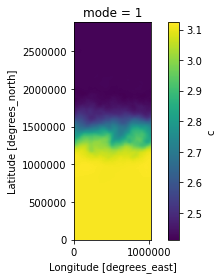

In [52]:
p = ds.c.sel(mode=1).plot(x='xi_rho',y='eta_rho')
p.axes.set_aspect('equal')

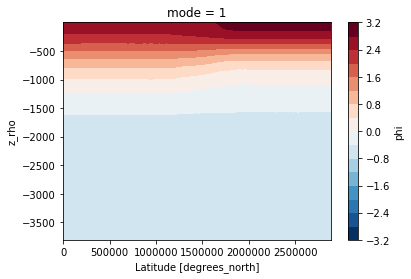

In [58]:
ds.phi.isel(x_rho=0, mode=1).plot.contourf(x='eta_rho', y='z_rho', levels=20)

/home1/datahome/nlahaye/miniconda3/envs/croco/lib/python3.7/site-packages/xarray/core/dataarray.py:1876: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()
/home1/datahome/nlahaye/miniconda3/envs/croco/lib/python3.7/site-packages/xarray/core/dataarray.py:1876: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()


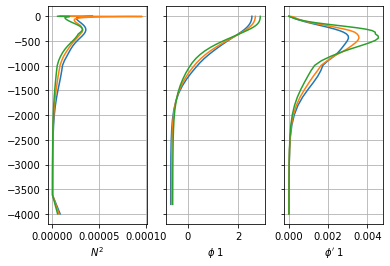

In [16]:
cn, phin, dphi = res

### PROBLEM: can't assign z_rho, z_w to DataArrays
phin["z_rho"] = zc #.assign_coords(z_rho=zc)
dphi["z_w"] = zf #.assign_coords(z_w=zf)

### plotting results at a few locations in y
inds = [10,360,700] # [1,100,200] #y or x indices for plotting
imod = 1

### can't plot using xarray builtins because of missing coord for s_w
fig, axs = plt.subplots(1, 3, sharey=True) # can't sharey because missing coord for s_w
axs[0].plot(N2f.isel(y_rho=inds), zf.isel(y_rho=inds))
axs[0].set_xlabel(r'$N^2$')
axs[1].plot(phin.sel(modes=imod).isel(y_rho=inds).T, zc.isel(y_rho=inds))
axs[1].set_xlabel(r'$\phi$ '+str(imod))
axs[2].plot(dphi.sel(modes=imod).isel(y_rho=inds).T, zf.isel(y_rho=inds))
axs[2].set_xlabel(r"$\phi'$ "+str(imod))

for ax in axs:
    ax.grid(True)
#phin.sel(modes=1).isel(x_rho=inds)
#dphi.sel(modes=1).isel(x_rho=[1,10,100]).plot.line(y='s_w', ax=axs[1])

In [13]:
### trying to understand why it does not work. 
### Using fake functions reproducing gradually the same process
### everything work with numpy arrays as entries. 
### Now fun_bid2 returns problem (when computing): replacement data must match the Variable's shape

jj = 20
zwean = get_z(r, zeta=sshmean, h=r.ds['his'].h, vgrid='w', hgrid='r')
zc = zmean.isel(x_rho=jj).chunk({'s_rho':-1}) # . chunk for parallel 
zf = zwean.isel(x_rho=jj).chunk({"s_w":-1})   # but does not work yet

#  function that just stack the
def fun_bid0(zr, zw):
    return np.concatenate([zr, zw], axis=-1)

def fun_bid1(zr, zw):
    """ this is just mimicking the stacking procedure of the wrapper
    no additional dimension modes """
    if zr.ndim>1:
        nxy = zr.shape[:-1]
        nn = np.prod(nxy)
        zr = zr.reshape(nn,zr.shape[-1])
        zw = zw.reshape(nn,zw.shape[-1])
        ii = 0
        an, bn = zr[ii,:], zw[ii,:]
        for ii in range(1,nn):
            res = zr[ii,:], zw[ii,:]
            an = np.vstack([an,res[0][None,...]])
            bn = np.vstack([bn,res[1][None,...]])
        return np.hstack([an,bn]).reshape(nxy+(-1,))
    else:
        return fun_bid0(zr,zw)
    
def fun_bid2(zr, zw):
    """ same as fun_bid1 but with additional dimension 'mode'
    this is the closest formulation from any compmode wrapper """
    _nmodes = 10
    assert (zr.ndim>1) & (zr.shape[-1]+1==zw.shape[-1]) & (zr.ndim==zw.ndim)
    nxy = zr.shape[:-1]
    _ns = zr.shape[-1]+zw.shape[-1]
    nn = np.prod(nxy)
    zr = zr.reshape(nn,zr.shape[-1]) # flatten arrays along serialized dims
    zw = zw.reshape(nn,zw.shape[-1])
    ii = 0
    an, bn = fomod(zr[ii,:], zw[ii,:], _nmodes) # inialize result (with extra 1st dim)
    an, bn = an[None,:], bn[None,:]
    for ii in range(1,nn):
        prov = fomod(zr[ii,:], zw[ii,:], _nmodes)
        an = np.vstack([an,prov[0][None,...]]) # stack result along first dim
        bn = np.vstack([bn,prov[1][None,...]])
    # stack results along z dim
    res = np.concatenate([an,bn], axis=-2).reshape(nxy+(_ns,_nmodes)) 
    return res

def fun_bid3(zr,zw):
    """ adding a dimension but not looping"""
    _nmodes = 10
    res = famad(zr,zw,_nmodes)
    return np.concatenate(res, axis=-2)

def fomod(zr,zw,nmodes):
    """ mimicking compmodes_1pt"""
    assert zr.ndim==zw.ndim==1
    return zr[:,None] + np.zeros(nmodes)[None,:], zw[:,None] + np.zeros(nmodes)[None,:]

def famad(zr,zw,nmodes):
    """add one dim of length nmodes, ndarrays as entries"""
    assert zr.ndim==zw.ndim
    return zr[...,None] + np.zeros(zr.shape+(nmodes,)), \
            zw[...,None] + np.zeros(zw.shape+(nmodes,))

case = 3 # warning case=2 will broadcast
lafun = fun_bid1 # only kept for case <=1
if case==1:
    res = xr.apply_ufunc(lafun, zc, zf, \
                     input_core_dims=[["s_rho"],["s_w"]], \
                    dask='parallelized', output_dtypes=[np.float64], \
                    output_core_dims=[["s_stack"]], output_sizes={"s_stack":r.N*2+1})
elif case==2:
    # if you don't specify core dims, then xarray broadcast over them 
    # (because output dim does not match)
    res = xr.apply_ufunc(lafun, zc.T, zf.T, \
                    dask='parallelized', output_dtypes=[np.float64], \
                    output_core_dims=[["s_stack"]], output_sizes={"s_stack":r.N*2+1})
elif case==3:
    lafun=fun_bid2
    res = xr.apply_ufunc(lafun, zc, zf, \
                     input_core_dims=[["s_rho"],["s_w"]], \
                    dask='parallelized', output_dtypes=[np.float64], \
                    output_core_dims=[["s_stack","mode"]], output_sizes={"mode":10,"s_stack":r.N*2+1})
res

/home1/datahome/nlahaye/croco-si/crocosi/gridop.py:106: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(sc.dims[0], _zeta.dims[0], _zeta.dims[1])


<xarray.DataArray (y_rho: 722, s_stack: 101, mode: 10)>
dask.array<fun_bid2, shape=(722, 101, 10), dtype=float64, chunksize=(722, 101, 10), chunktype=numpy.ndarray>
Coordinates:
    eta_rho  (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
    xi_rho   (y_rho) float32 78000.0 78000.0 78000.0 ... 78000.0 78000.0 78000.0
    f        (y_rho) float32 0.00010309763 0.00010316237 ... 0.00014977805
Dimensions without coordinates: y_rho, s_stack, mode

In [14]:
res.compute()

<xarray.DataArray (y_rho: 722, s_stack: 101, mode: 10)>
array([[[-3.80609576e+03, -3.80609576e+03, -3.80609576e+03, ...,
         -3.80609576e+03, -3.80609576e+03, -3.80609576e+03],
        [-3.44605886e+03, -3.44605886e+03, -3.44605886e+03, ...,
         -3.44605886e+03, -3.44605886e+03, -3.44605886e+03],
        [-3.12010228e+03, -3.12010228e+03, -3.12010228e+03, ...,
         -3.12010228e+03, -3.12010228e+03, -3.12010228e+03],
        ...,
        [-4.50451138e+00, -4.50451138e+00, -4.50451138e+00, ...,
         -4.50451138e+00, -4.50451138e+00, -4.50451138e+00],
        [-1.75006185e+00, -1.75006185e+00, -1.75006185e+00, ...,
         -1.75006185e+00, -1.75006185e+00, -1.75006185e+00],
        [ 4.68163252e-01,  4.68163252e-01,  4.68163252e-01, ...,
          4.68163252e-01,  4.68163252e-01,  4.68163252e-01]],

       [[-3.80609576e+03, -3.80609576e+03, -3.80609576e+03, ...,
         -3.80609576e+03, -3.80609576e+03, -3.80609576e+03],
        [-3.44605886e+03, -3.44605886e+03, -3.4

In [18]:
# trying different wrappers
def wrap1(zr, zw):
    """ adapted from fun_bid2 """
    _nmodes = 10
    assert (zr.ndim>1) & (zr.shape[-1]+1==zw.shape[-1]) & (zr.ndim==zw.ndim)
    nxy = zr.shape[:-1]
    _ns = zr.shape[-1]+zw.shape[-1]
    nn = np.prod(nxy)
    zr = zr.reshape(nn,zr.shape[-1]) # flatten arrays along serialized dims
    zw = zw.reshape(nn,zw.shape[-1])
    N2 = zw*0 + 1

    ii = 0
    _, an, bn = compmodes_1pt(zr[ii,:], zw[ii,:], N2[ii,:], nmodes=_nmodes) # inialize result (with extra 1st dim)
    an, bn = an[None,:], bn[None,:]
    for ii in range(1,nn):
        prov = compmodes_1pt(zr[ii,:], zw[ii,:], N2[ii,:], nmodes=_nmodes)
        an = np.vstack([an,prov[1][None,...]]) # stack result along first dim
        bn = np.vstack([bn,prov[2][None,...]])
    # stack results along z dim
    res = np.concatenate([an,bn], axis=-2).reshape(nxy+(_ns,_nmodes)) 
    return res

lafun = wrap1
res = xr.apply_ufunc(lafun, zc, zf, \
                input_core_dims=[["s_rho"],["s_w"]], \
                dask='parallelized', output_dtypes=[np.float64], \
                output_core_dims=[["s_stack","mode"]], \
                output_sizes={"mode":10,"s_stack":r.N*2+1})
res

### WARNING: trying to evaluate this will trigger "serialize" error and crash your kernel
### this tend to show that the problem is with compmodes_1pt, 
### because that's the only difference between fun_bid2 and wrap1.  

<xarray.DataArray (y_rho: 722, s_stack: 101, mode: 10)>
dask.array<wrap1, shape=(722, 101, 10), dtype=float64, chunksize=(722, 101, 10), chunktype=numpy.ndarray>
Coordinates:
    eta_rho  (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
    xi_rho   (y_rho) float32 78000.0 78000.0 78000.0 ... 78000.0 78000.0 78000.0
    f        (y_rho) float32 0.00010309763 0.00010316237 ... 0.00014977805
Dimensions without coordinates: y_rho, s_stack, mode

In [ ]:
### here it fails
res.compute()

distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/home1/datahome/nlahaye/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/protocol/core.py", line 44, in dumps
    for key, value in data.items()
  File "/home1/datahome/nlahaye/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/protocol/core.py", line 45, in <dictcomp>
    if type(value) is Serialize
  File "/home1/datahome/nlahaye/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/protocol/serialize.py", line 167, in serialize
    for obj in x
  File "/home1/datahome/nlahaye/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/protocol/serialize.py", line 167, in <listcomp>
    for obj in x
  File "/home1/datahome/nlahaye/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/protocol/serialize.py", line 210, in serialize
    raise TypeError(msg, str(x)[:10000])
TypeError: ('Could not serialize object of type SubgraphCallable.', 'subg

### tries and tribes for v-mode computation and wrapping into xarray

In [32]:
def compmodes(zc_nd, zf_nd, N2f_nd, nmodes, free_surf=True, g=9.81, sigma=.1, stacked=True, debug=False):
    """
    wrapper for 'vectorizing' compmodes_1p over elements of axes other than vertical dim
    that's not elegant, nor efficient
    here z is last axis because it is core dim
    """
    assert zc_nd.ndim==zf_nd.ndim==N2f_nd.ndim
    assert zf_nd.shape==N2f_nd.shape
    if zc_nd.ndim>1:
        nxy = zc_nd.shape[:-1]
        nn = np.prod(nxy)
        zc_nd = zc_nd.reshape(nn,zc_nd.shape[-1])
        zf_nd = zf_nd.reshape(nn,zf_nd.shape[-1])
        N2f_nd = N2f_nd.reshape(nn,N2f_nd.shape[-1])
        ii = 0
        cn, phin, dphi = compmodes_1pt(zc_nd[ii,:], zf_nd[ii,:], N2f_nd[ii,:], nmodes, \
                                free_surf=free_surf, g=g, sigma=sigma, debug=debug)
        cn, phin, dphi = cn[None,:], phin[None,...], dphi[None,...]
        for ii in range(1,nn):
            res = compmodes_1pt(zc_nd[ii,:], zf_nd[ii,:], N2f_nd[ii,:], nmodes, \
                                free_surf=free_surf, g=g, sigma=sigma, debug=debug)
            cn = np.vstack([cn, res[0][None,...]])
            phin = np.vstack([phin,res[1][None,...]])
            dphi = np.vstack([dphi,res[2][None,...]])
        if stacked:
            return np.hstack([cn[:,None,:],phin,dphi]).reshape(nxy+(-1,nmodes+1))
        else:
            return cn.reshape(nxy+(nmodes,)), phin.reshape(nxy+(-1,nmodes)), \
                        dphi.reshape(nxy+(-1,nmodes))
    else:
        return compmodes_1pt(zc_nd, zf_nd, N2f_nd, nmodes, \
                                free_surf=free_surf, g=g, sigma=sigma, debug=debug)

x = np.arange(0,10)
_zc = np.arange(-1000+5,-5,10)[None,None,:] + 0*x[:,None,None]
_zf = np.arange(-1000,0,10)[None,None,:] + 0*x[:,None,None]
N2 = _zf*0 + 1e-3

res = compmodes(_zc, _zf, N2, 10)
res

array([[[[ 1.00203604e+02,  9.86578495e+00,  4.97076367e+00, ...,
           1.24880193e+00,  1.11087643e+00,  1.00061135e+00],
         [ 1.02146475e+00, -1.41409425e+00,  1.41881565e+00, ...,
           1.40978637e+00, -1.40677794e+00,  1.40340857e+00],
         [ 1.02145458e+00, -1.41264142e+00,  1.41307343e+00, ...,
           1.31938683e+00, -1.29278078e+00,  1.26323915e+00],
         ...,
         [-9.71460218e-05,  1.46490749e-04,  1.00253119e-03, ...,
           1.73745257e-02,  2.17548967e-02,  2.65185720e-02],
         [-9.81155616e-05,  1.20828582e-06,  4.29829908e-04, ...,
           8.90078064e-03,  1.12620535e-02,  1.38809569e-02],
         [-9.90841242e-05, -1.44075419e-04, -1.44610981e-04, ...,
          -1.43707964e-04, -1.43401540e-04, -1.43058252e-04]]],


       [[[ 1.00203604e+02,  9.86578495e+00,  4.97076367e+00, ...,
           1.24880193e+00,  1.11087643e+00,  1.00061135e+00],
         [ 1.02146475e+00, -1.41409425e+00,  1.41881565e+00, ...,
           1.4097863

In [97]:
### apply ufunc single point
nmodes = 10
stacked = True # stack result from modes to allow for parallelization
jj = 20
zc = zmean.isel(x_rho=jj,y_rho=jj).chunk({'s_rho':-1})
zf = zwean.isel(x_rho=jj,y_rho=jj).chunk({"s_w":-1})
N2f = N2.isel(x_rho=jj,y_rho=jj).chunk({"s_w":-1})


if not stacked:
    %time res = xr.apply_ufunc(compmodes, zc, zf, N2f, nmodes, \
                     input_core_dims=[["s_rho"],["s_w"],["s_w"],[]], \
                    dask='allowed', output_dtypes=[np.float64,np.float64,np.float64], \
                    output_core_dims=[["modes"],["s_rho","modes"],["s_w","modes"]], \
                    vectorize=True)
else:
    %time res = xr.apply_ufunc(compmodes, zc, zf, N2f, kwargs={nmodes=nmodes, 'stacked':True}, \
                     input_core_dims=[["s_rho"],["s_w"],["s_w"],[]], \
                    dask='parallelized', output_dtypes=[np.float64], \
                    output_core_dims=[["s_stack","modes"]], output_sizes={"modes":nmodes+1,"s_stack":2*(r.N+1)})
res

ValueError: size of dimension 's_rho' on inputs was unexpectedly changed by applied function from 50 to 102. Only dimensions specified in ``exclude_dims`` with xarray.apply_ufunc are allowed to change size.

<xarray.DataArray (s_stack: 102, modes: 11)>
dask.array<compmodes, shape=(102, 11), dtype=float64, chunksize=(102, 11), chunktype=numpy.ndarray>
Coordinates:
    eta_rho  float32 78000.0
    xi_rho   float32 78000.0
    f        float32 0.00010439251
Dimensions without coordinates: s_stack, modes

CPU times: user 4.79 s, sys: 88 ms, total: 4.88 s
Wall time: 4.77 s
(722, 11) (722, 50, 11) (722, 51, 11)
cn: [1.46190676 1.29627839 0.84615651]


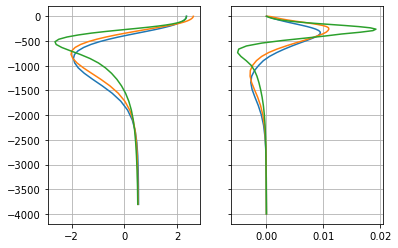

In [83]:
# do it with numpy
ix, jy = 20, 20
%time zr = zmean.isel(x_rho=20).values.T
%time zw = zwean.isel(x_rho=20).values.T
%time bvf = N2.isel(x_rho=20).values.T

%time res = compmodes(zr, zw, bvf, nmodes, stacked=True)
res.shape
# extract info
cn = res[:,0,:]
phin = res[:,1:r.N+1,:]
dphi = res[:,r.N+1:,:]
print(cn.shape, phin.shape, dphi.shape)

# plot result
inds = [1, 350, 700]
imod = 2
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].plot(phin[inds,:,imod].T, zr[inds,:].T)
axs[1].plot(dphi[inds,:,imod].T, zw[inds,:].T)
print("cn:",cn[inds,imod])
for ax in axs:
    ax.grid(True)

/home1/datahome/nlahaye/croco-si/crocosi/gridop.py:109: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(sc.dims[0], _zeta.dims[0], _zeta.dims[1])


starting now
input shapes: (50,) (51,) (51,)
(51,) (51,) (2, 51) (50, 51)
constructed matrix A with shape (50, 50)
compute eigenmodes with shape (11,) (50, 11)
sorted and normalized modes with shape (50, 11)
checked modes and computed dphi ; now returning results


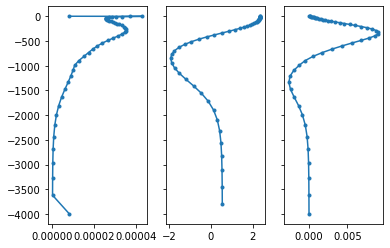

In [116]:
# do it with numpy, just to check that it works -- single x, y point

ix, jy = 20, 20
zr = zmean.isel(y_rho=20).values
zw = zwean.isel(y_rho=20).values
bvf = N2.isel(y_rho=20).values

res = compmodes(zr, zw, bvf, 10)

### OK, that works
imod = 2
fig, axs = plt.subplots(1, 3, sharey=True)
axs[0].plot(bvf, zw, ".-")
axs[1].plot(res[1][:,imod], zr, ".-")
axs[2].plot(res[2][:,imod], zw, '.-')

# Projection of a variable on vertical modes

**Interpolation of the variable on zmean -> var(x,y,$\bar{z}$,t)**

In [49]:
# define get_p (not sure this is correct)
# it would be nice to be able to interpolate from w-grid to r-grid (e.g. get rid of broadcasting)
# I think p is wrong for now

def get_p_zmoy(ds, zr, zw, rho, zrho=None):
    _g = 9.81
    grid = ds.attrs['xgcm-Grid']
    if zrho is not None:
        rho = xr.apply_ufunc(interp2z, zr, zrho, rho, False, \
                    dask='parallelized', output_dtypes=[np.float64])
    pres =  grid.cumsum(grid.diff(zw, "s")*rho*_g, "s", to="outer", boundary="fill") 
    pres = pres - pres.isel(s_w=-1) # how to get cumsum going the other way ?
    return grid.interp(pres, "s")

def get_p(r, ds, rho, zeta, z=None):
    """ this is the baroclinic pressure, without rho0*zeta and int(rho0) """
    # this is a bit wrong, because variable boundary for integration of rho makes pressure nonlinear
    
    _g = 9.81
    zw = get_z(r, zeta, h=ds.h, vgrid='w', hgrid='r')
    grid = ds.attrs['xgcm-Grid']
    pres =  grid.cumsum(grid.diff(zw, "s")*rho*_g, "s", to="outer", boundary="fill") 
    if z is None:
        return grid.interp(pres, "s")
    else:
        return xr.apply_ufunc(interp2z, z, zw.chunk({'s_w':-1}), pres.chunk({'s_w':-1}), False, \
                    input_core_dims=[['s_rho'],['s_w'],['s_w'],[]], output_core_dims=[['s_rho']], \
                    dask='parallelized', output_dtypes=[np.float64])


In [50]:
# project p, u and v
### not using interpolated field because can't extrapolate, hence nan                                        

ds = r['his']
grid = ds.attrs['xgcm-Grid']
dz = grid.diff(zf, "s")
hwean = np.abs(zwean.isel(s_w=-1)-zwean.isel(s_w=0))

### first pressure
#pp = get_p(r, ds, ds.T_t_cos, ds.ssh_t_cos)
pp = get_p_zmoy(ds, zmean, zwean, ds.T_t_cos, z)
pn = (dz*pp*phin).sum("s_rho")/hwean

### then x-velocity
ur = grid.interp(ds.u_t_cos, "xi").rename({'y_u':'y_rho'}) # question: does grid.interp know how to broadcast?
#ur = xr.apply_ufunc(interp2z, zmean, z, ur, True, 
#                    dask='parallelized', output_dtypes=[np.float64])
un = (dz*ur*phin).sum("s_rho")/hwean

### then y-velocity
vv = r['his'].v_t_cos
vr = grid.interp(vv, "eta").rename({'x_v':'x_rho'})
vn = (dz*vr*phin).sum("s_rho")/hwean


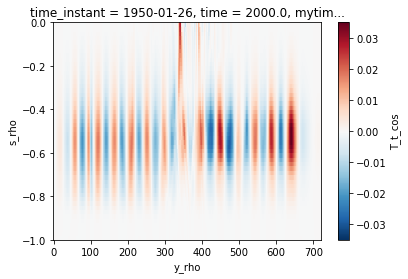

In [63]:
ds.T_t_cos.isel(time=0,x_rho=jj).plot()

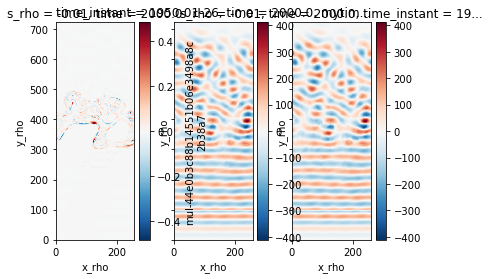

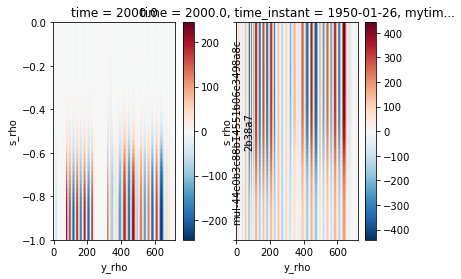

In [72]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)

psurf = pp.isel(s_rho=-1).isel(time=0)
etap = (ds.ssh_t_cos*(r.params['rho0']+T.isel(s_rho=-1))*9.81).isel(time=0)

psurf.plot(ax=axs[0])
etap.plot(ax=axs[1])
(psurf+etap).plot(ax=axs[2])

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
psec = pp.isel(x_rho=jj).isel(time=0)
ptot = psec + etap.isel(x_rho=jj)
psec.plot(ax=axs[0])
pbcl.plot(ax=axs[1])

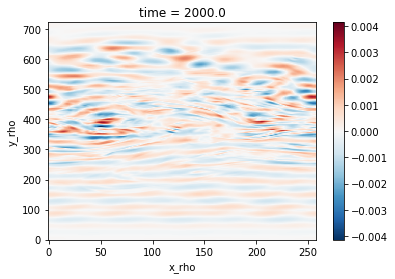

In [127]:
un.isel(time=0,modes=0).plot(x="x_rho")

In [17]:
### u2rho returns " KeyError: 'X' "
uu = r['his'].u_t_cos.isel(x_u=[jj,jj+1]).mean("x_u")

ui = xr.apply_ufunc(interp2z, zmean, z, uu, False, 
                    dask='parallelized', output_dtypes=[np.float64])

### I need to switch dim from "s_w" to "s_rho" for dz
### same for u, v -> need u2rho, v2rho and have xarray understand y_u = y_rho
un = (zwean.diff('s_w')*ui*phin).sum("s_rho")

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 16.3 ms
